<a href="https://colab.research.google.com/github/AdarshRavis/PatchNN/blob/main/Patch_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setting Up**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import seaborn


from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample

import cv2

In [ ]:
skin_df = pd.read_pickle('DATA.pkl')
skin_df.head()

## **Balancing the Dataset**

In [ ]:
df_0 = skin_df[skin_df['ReactBin'] == 0]
df_1 = skin_df[skin_df['ReactBin'] == 1]
print('There are',df_0.shape[0],'patches with NO REACTION')
print('there are',df_1.shape[0],'patches with REACTION')

There are 13194 patches with NO REACTION
there are 428 patches with REACTION


In [ ]:
df_0_shuffled = shuffle(df_0, random_state=123)
df_1_shuffled = shuffle(df_1, random_state=123)
print('df_0 and df_1 are now shuffled')

df_0 and df_1 are now shuffled


In [ ]:
df_0_train_orig, df_0_test = train_test_split(df_0_shuffled, test_size=0.2, random_state = 123)
df_0_train, df_0_validate = train_test_split(df_0_train_orig, test_size=0.25, random_state = 123)
df_1_train_orig, df_1_test = train_test_split(df_1_shuffled, test_size=0.2, random_state = 123)
df_1_train, df_1_validate = train_test_split(df_1_train_orig, test_size=0.25, random_state = 123)

print('df_0_train has',df_0_train.shape[0],'patches')
print('df_0_validate has',df_0_validate.shape[0],'patches')
print('df_0_test has',df_0_test.shape[0],'patches')
print('In total, df_0 has',df_0_train.shape[0]+df_0_validate.shape[0]+df_0_test.shape[0], 'negative patches')
print('\n')
print('df_1_train has',df_1_train.shape[0],'patches')
print('df_1_validate has',df_1_validate.shape[0],'patches')
print('df_1_test has',df_1_test.shape[0],'patches')
print('In total, df_1 has',df_1_train.shape[0]+df_1_validate.shape[0]+df_1_test.shape[0], 'positive patches')

df_0_train has 7916 patches
df_0_validate has 2639 patches
df_0_test has 2639 patches
In total, df_0 has 13194 negative patches


df_1_train has 256 patches
df_1_validate has 86 patches
df_1_test has 86 patches
In total, df_1 has 428 positive patches


In [ ]:
df_1_train_resampled = resample(df_1_train, replace=True, n_samples=df_0_train.shape[0], random_state=123)
df_1_validate_resampled = resample(df_1_validate, replace=True, n_samples=df_0_validate.shape[0], random_state=123) 
df_1_test_resampled = resample(df_1_test, replace=True, n_samples=df_0_test.shape[0], random_state=123)

print('We have now resampled the positive patch data to equal that of the negative patch data')
print('df_1_train_resampled has',df_1_train_resampled.shape[0],'positive patches')
print('df_1_validate_resampled has',df_1_validate_resampled.shape[0],'positive patches')
print('df_1_test_resampled has',df_1_test_resampled.shape[0],'positive patches')

We have now resampled the positive patch data to equal that of the negative patch data
df_1_train_resampled has 7916 positive patches
df_1_validate_resampled has 2639 positive patches
df_1_test_resampled has 2639 positive patches


In [ ]:
df_train_balanced = pd.concat([df_0_train, df_1_train_resampled])
df_validate_balanced = pd.concat([df_0_validate, df_1_validate_resampled])
df_test_balanced = pd.concat([df_0_test, df_1_test])
print('We have now concatenated the train, validate, and test datasets!')

We have now concatenated the train, validate, and test datasets!


## **Normalizing Images**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [ ]:
X_train =df_train_balanced.drop(columns=['ReactBin'],axis=1)
X_validate =df_validate_balanced.drop(columns=['ReactBin'],axis=1)
X_test =df_test_balanced.drop(columns=['ReactBin'],axis=1)
y_train =df_train_balanced['ReactBin']
y_validate =df_validate_balanced['ReactBin']
y_test =df_test_balanced['ReactBin']

X_train = np.asarray(X_train['image'].tolist())
X_validate = np.asarray(X_validate['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())

X_train = X_train/255
X_validate = X_validate/255
X_test = X_test/255

X_train = X_train.reshape(X_train.shape[0], *(100, 100, 3))
X_test = X_test.reshape(X_test.shape[0], *(100, 100, 3))
X_validate = X_validate.reshape(X_validate.shape[0], *(100, 100, 3))

In [ ]:
datagen.fit(X_train)
datagen.fit(X_validate)
datagen.fit(X_test)

## **Building the Model**

In [ ]:
input_shape = (100, 100, 3)
num_classes = 2

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))  


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        1

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["binary_accuracy"])

In [ ]:
epochs = 200
batch_size = 64

In [ ]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_validate,y_validate),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              )

In [ ]:
# Uncomment when you want to save!
# model.save('saved_model.h5')

## **Visualizing the Results**

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Patch_NN/TestPatch_20210525_1.h5')

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['binary_accuracy'])+1),model_history.history['binary_accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_binary_accuracy'])+1),model_history.history['val_binary_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['binary_accuracy'])+1),len(model_history.history['binary_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
  
plot_model_history(history)

In [ ]:
# Run the model on the test dataset
model.evaluate(X_test, y_test)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
mythreshold=0.089938596
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
plot_confusion_matrix(cm, classes = range(2))



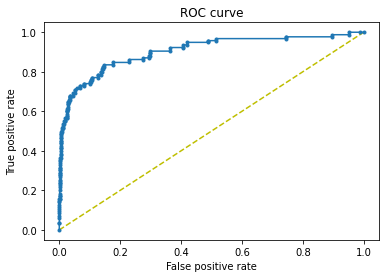

Ideal threshold is:  124    0.038283
Name: thresholds, dtype: float32
Area under curve, AUC =  0.9059069075075661


In [ ]:
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 


from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [ ]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(y_test, y_preds)
print(threshold)

[0.03828272223472595]


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

Accuracy = accuracy_score(y_test,y_pred)
Precision = precision_score(y_test,y_pred)
Recall = recall_score(y_test,y_pred)


print('Accuracy:' + str(Accuracy))
print('Precision (PPV):' + str(Precision))
print('Recall (Sensitivity):' + str(Recall))
print('')
print('')


from sklearn.metrics import classification_report


print('Classification report')
print('')
print(classification_report(y_test,y_pred))

In [ ]:
num= 1  #Select the index of image to be loaded for testing
img = X_test[num]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("This was labeled as: ",(model.predict(input_img)>= mythreshold).astype(int))
print("The actual label for this image is: ", np.array(y_test)[num])